In [33]:
import numpy as np
import pandas as pd
import scanpy as sc
import os


num_of_clusters = 5
datasetNum = 1

ToolName = 'scanpy' 
DatasetName = 'tabula-muris-heart'
Data_path = '../dataset/{}-filtered/10X/'.format(DatasetName)
save_path = '../results/{}/{}/'.format(DatasetName, ToolName)

if not os.path.exists(save_path):
    os.makedirs(save_path)


# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [34]:
adata = sc.read_10x_mtx(
    Data_path,  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=False
)

In [35]:
#scale_factor = 10000
#
#sc.pp.normalize_per_cell(adata) # same as seurat NormalizeData
#
#adata.X = adata.X * scale_factor # seurat scale.factor
#sc.pp.log1p(adata)

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# sc.pp.scale(adata.X)  # mean=0, var=1

(13656, 1)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 13656 and the array at index 1 has size 1

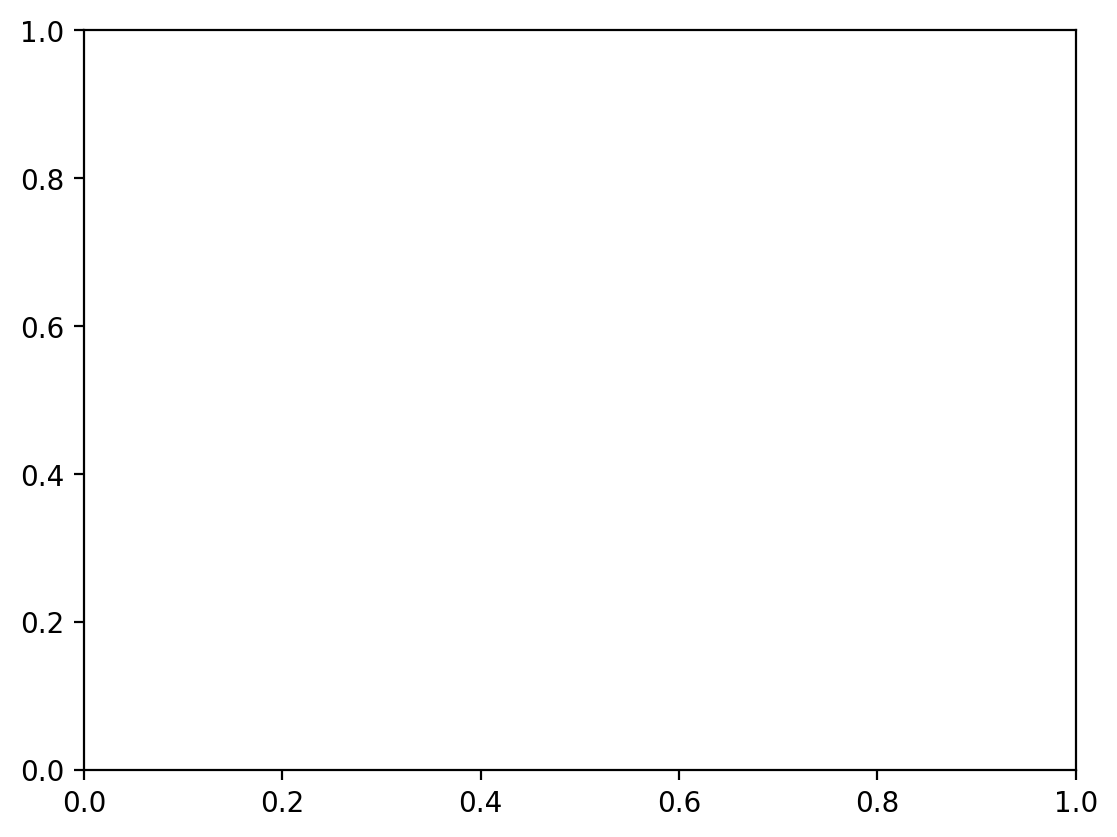

In [55]:
import matplotlib.pyplot as plt
matrix = adata.X
# from sparse matrix to dense matrix
matrix = matrix.todense()
# find the most variable features (columns) of the matrix sorted by variance
sorted_array = np.var(matrix, axis=0)
sorted_array = np.sort(sorted_array)
sorted_array = sorted_array.T
print(sorted_array.shape)
# plot the variance of the features
plt.scatter([i for i in range(len(sorted_array))], sorted_array)


In [21]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3') # seurat FindVariableFeatures

ImportError: Please install skmisc package via `pip install --user scikit-misc

In [45]:
sc.tl.pca(adata, svd_solver='arpack', n_comps=50, use_highly_variable=True)
# same number of PCs as seurat

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


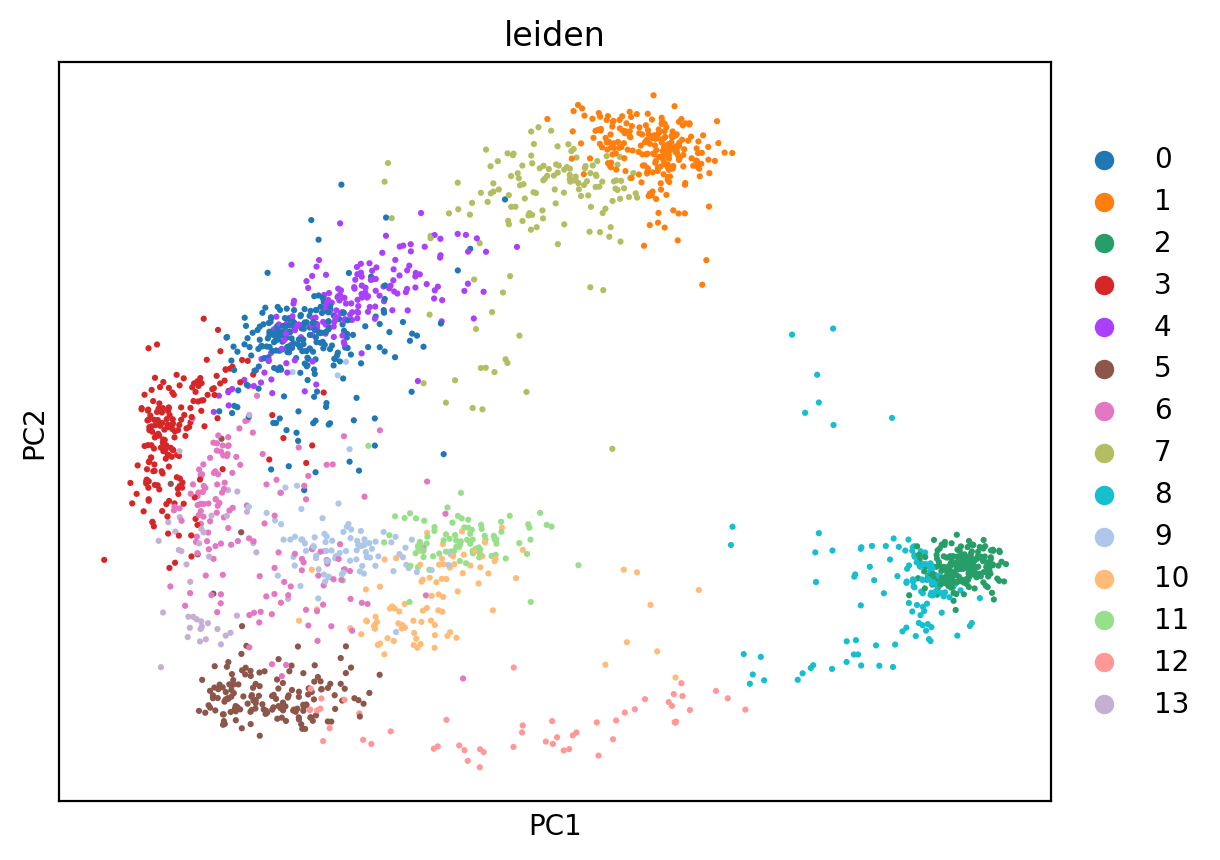

In [46]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=10)    # 15 è il default di scanpy
# forse n_neighbors è l'equivalente di k.param in seurat
res = 0.001
sc.tl.leiden(adata, resolution=res)
while not (adata.obs.leiden.values.categories.values).shape == (num_of_clusters[datasetNum],) or res == 1.0:
    res += 0.005
    sc.tl.leiden(adata, resolution=res)
    
sc.pl.pca(adata, color=['leiden'], size=20)

In [37]:
# cluster id for each cell renamed as cluster

df = pd.DataFrame(adata.obs['leiden'])

labels = df.rename(columns={'leiden': 'cluster'})
labels.index.name = 'cell'

labels['cluster'] = labels['cluster'].astype(int) + 1

labels.to_csv(f'{save_path}/clustering_labels.csv', index=True)

In [38]:
# silouhette score
matrix = adata.X

from sklearn.metrics import silhouette_score
score = silhouette_score(matrix, labels, metric='euclidean')

# dataset with silouette score

df = pd.DataFrame([score], columns=['silhouette'])
df.to_csv(f'{save_path}/clustering_scores.csv', index=False)

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


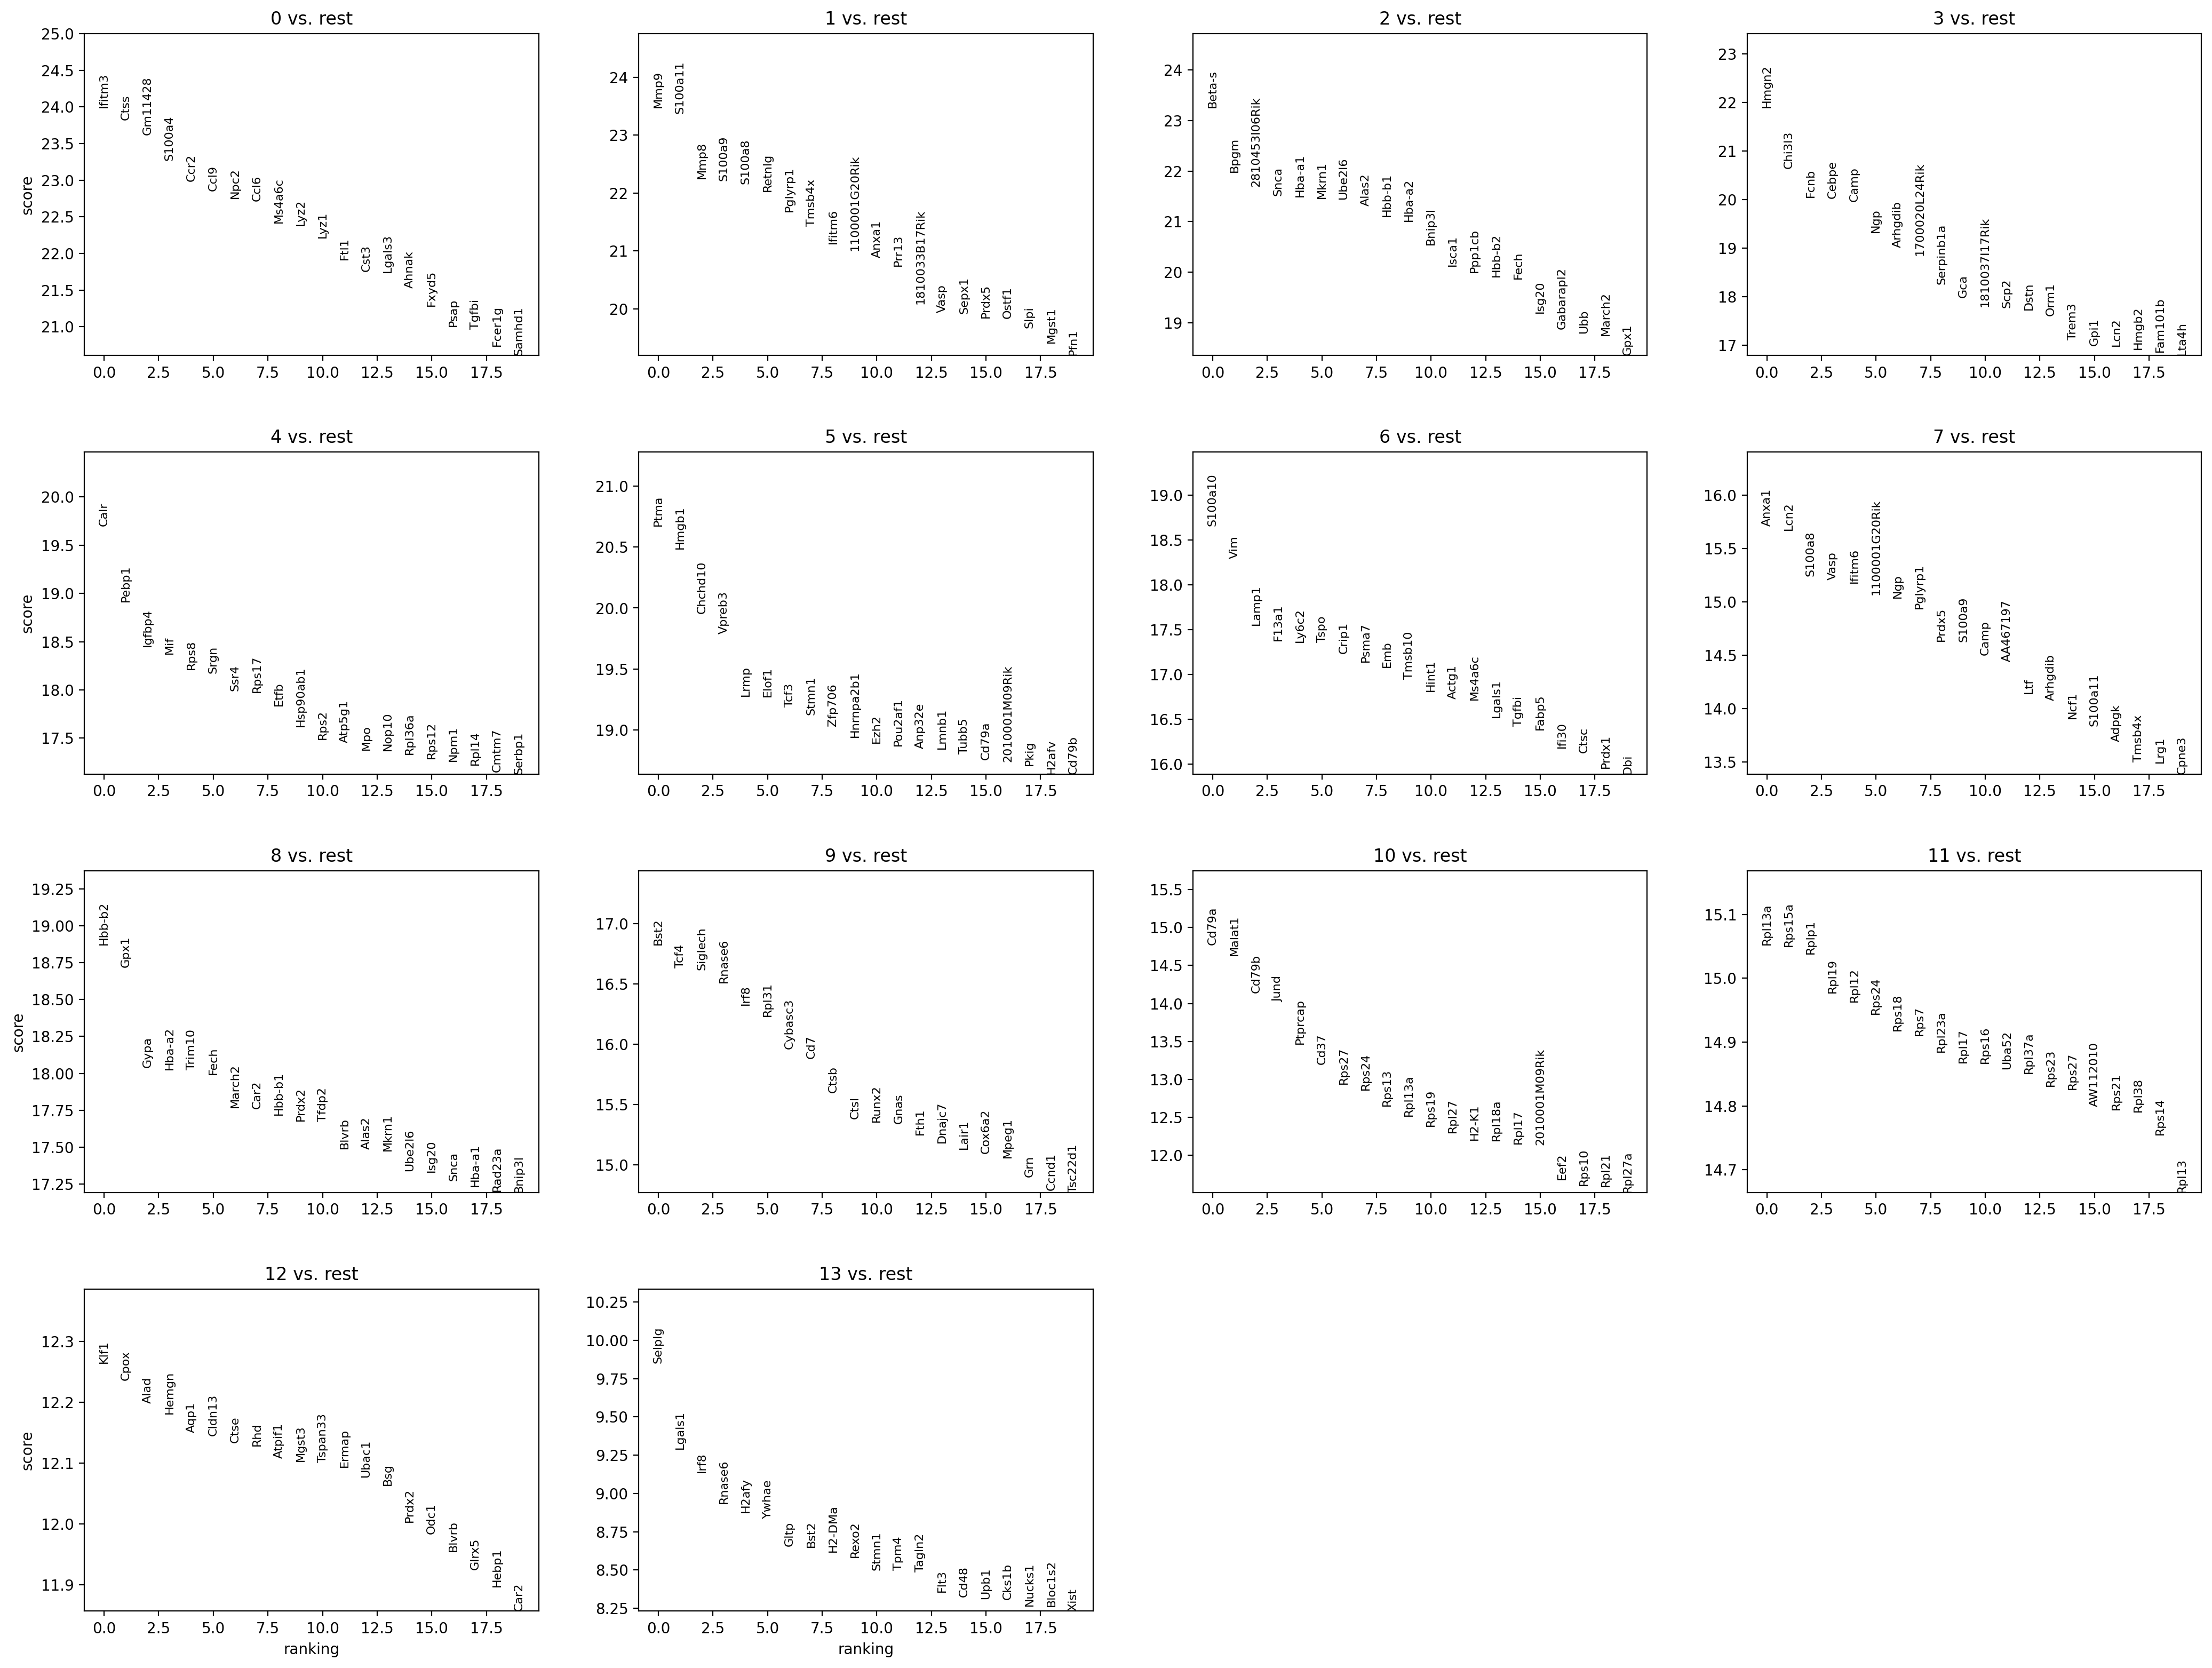

In [39]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon') # method='wilcoxon' method='logreg'
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [40]:
number_of_clusters = num_of_clusters[datasetNum]
number_of_genes = 20

names = adata.uns['rank_genes_groups']['names'][:number_of_genes]
# transform each element of names in a list
names = [list(x) for x in names]

df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])

for i in range(number_of_clusters):
    to_add = [ [names[j][i], i, j] for j in range(number_of_genes)]
    to_add = pd.DataFrame(to_add, columns=['gene', 'cluster', 'rank'])
    df = pd.concat([df, to_add],  ignore_index=True)


df['cluster'] = df['cluster'].astype(int) + 1
df['rank'] = df['rank'].astype(int) + 1

df.to_csv(f'{save_path}/markers.csv', index=False)

# other things

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sc.pl.pca(adata, color='Beta-s')

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

In [ ]:
sc.tl.umap(adata)

In [ ]:
sc.pl.umap(adata, color=['Beta-s', 'Malat1'])

In [ ]:
sc.tl.leiden(adata, resolution=0.4)

In [ ]:
sc.pl.umap(adata, color=['leiden', 'Beta-s', 'Malat1'])

In [ ]:
ret = sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [ ]:
number_of_clusters = 8
number_of_genes = 20

names = adata.uns['rank_genes_groups']['names'][:number_of_genes]
# transform each element of names in a list
names = [list(x) for x in names]

df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])

for i in range(0, number_of_clusters):
    to_add = [ [names[j][i], i, j] for j in range(number_of_genes)]
    to_add = pd.DataFrame(to_add, columns=['gene', 'cluster', 'rank'])
    df = pd.concat([df, to_add],  ignore_index=True)

df

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [2]:
adata = sc.read_10x_mtx(
    Data_path,  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=False
)

In [4]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3') # seurat FindVariableFeatures

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-pac

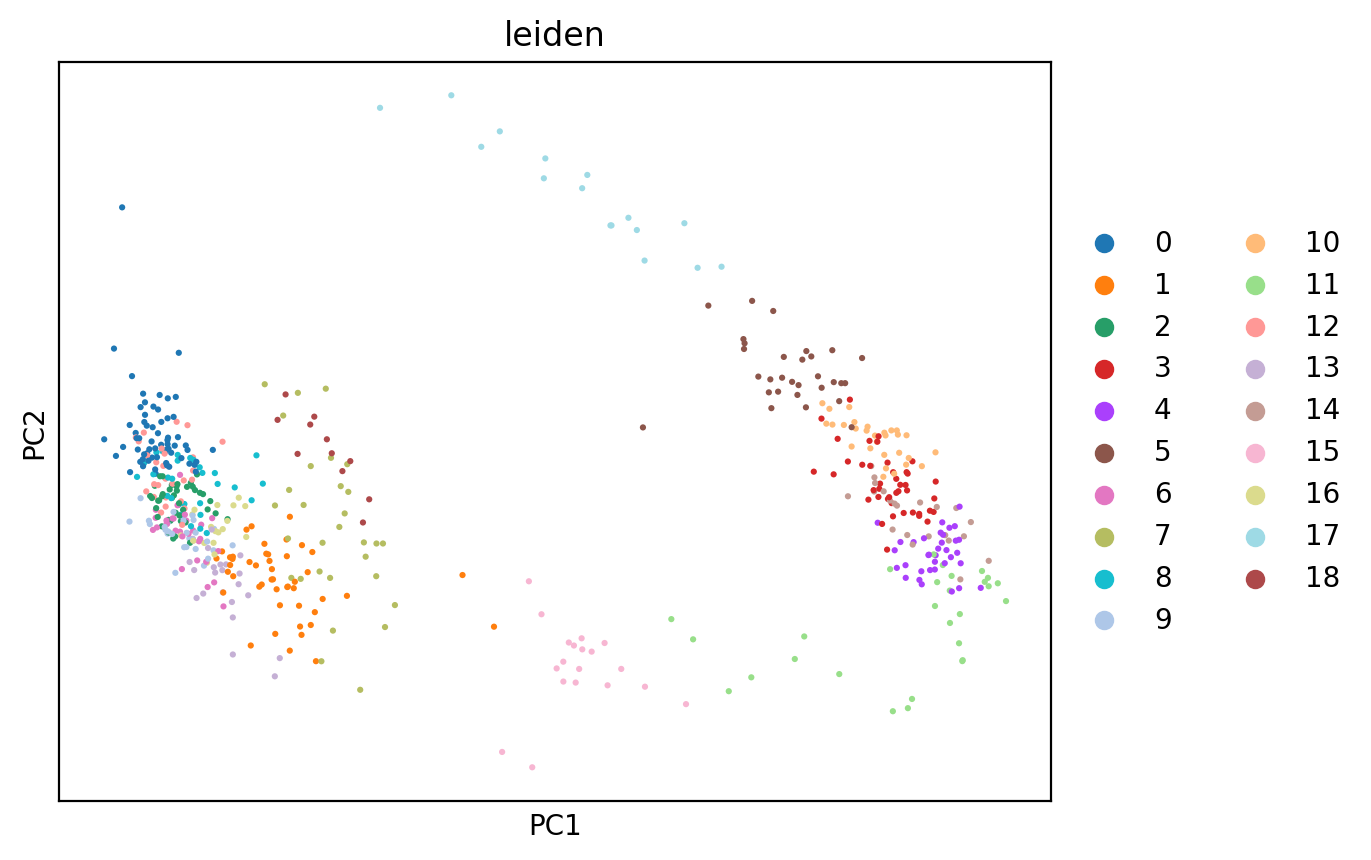

In [6]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=10)    # 15 è il default di scanpy
# forse n_neighbors è l'equivalente di k.param in seurat

sc.tl.leiden(adata, resolution=0.059)

res = 0.01
sc.tl.leiden(adata, resolution=res)
while not (adata.obs.leiden.values.categories.values).shape == (num_of_clusters[datasetNum],) or res == 1.0:
    res += 0.01
    sc.tl.leiden(adata, resolution=res)
    
sc.pl.pca(adata, color=['leiden'], size=20)

In [8]:
# silouhette score
matrix = adata.X

from sklearn.metrics import silhouette_score
score = silhouette_score(matrix, labels, metric='euclidean')

# dataset with silouette score

df = pd.DataFrame([score], columns=['silhouette'])
df.to_csv(f'{save_path}/clustering_scores.csv', index=False)

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [10]:
number_of_clusters = num_of_clusters[datasetNum]
number_of_genes = 20

names = adata.uns['rank_genes_groups']['names'][:number_of_genes]
# transform each element of names in a list
names = [list(x) for x in names]

df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])

for i in range(number_of_clusters):
    to_add = [ [names[j][i], i, j] for j in range(number_of_genes)]
    to_add = pd.DataFrame(to_add, columns=['gene', 'cluster', 'rank'])
    df = pd.concat([df, to_add],  ignore_index=True)


df['cluster'] = df['cluster'].astype(int) + 1
df['rank'] = df['rank'].astype(int) + 1

df.to_csv(f'{save_path}/markers.csv', index=False)

# other things

KeyError: 'Could not find key Beta-s in .var_names or .obs.columns.'

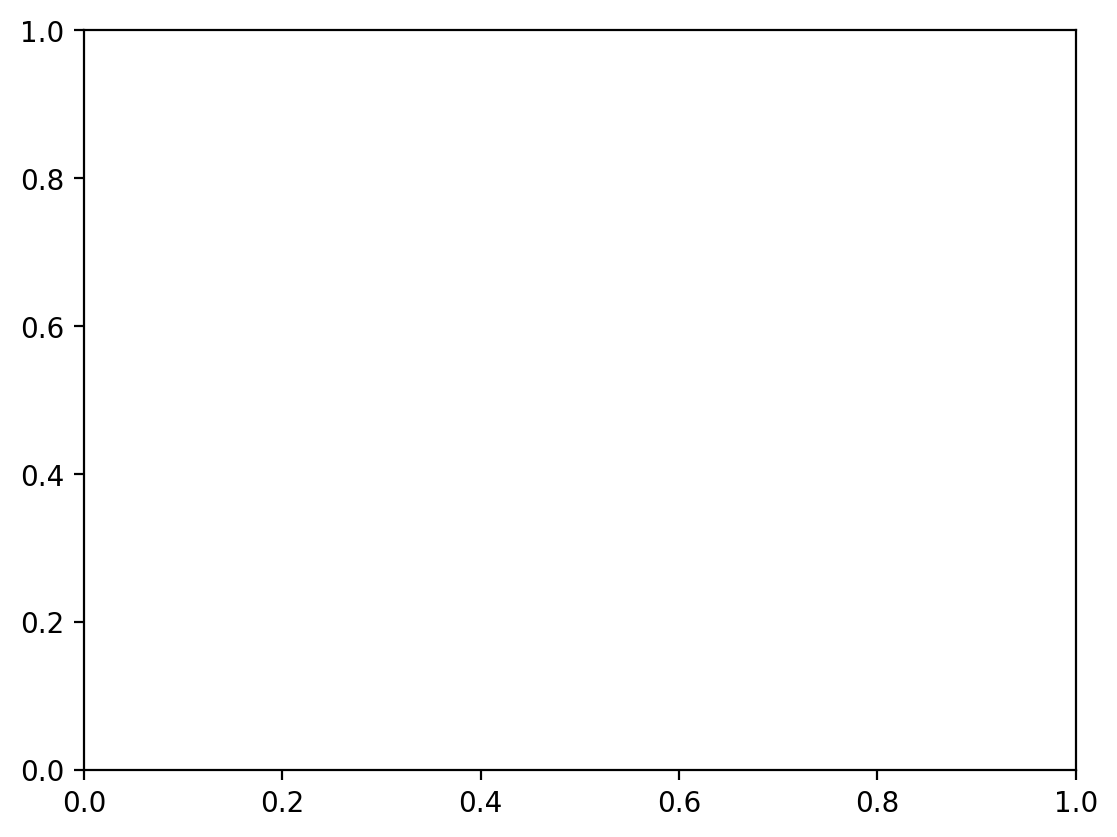

In [12]:
sc.pl.pca(adata, color='Beta-s')

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

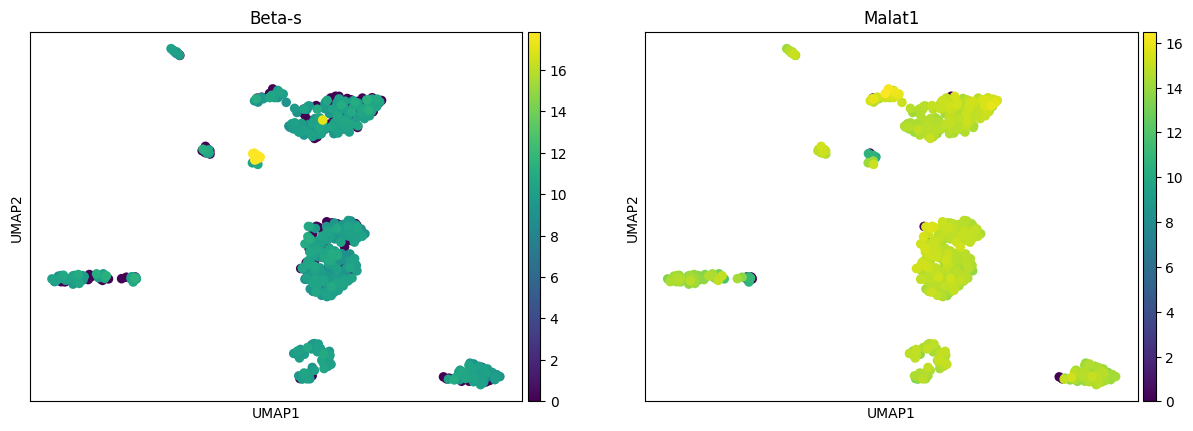

In [ ]:
sc.pl.umap(adata, color=['Beta-s', 'Malat1'])

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


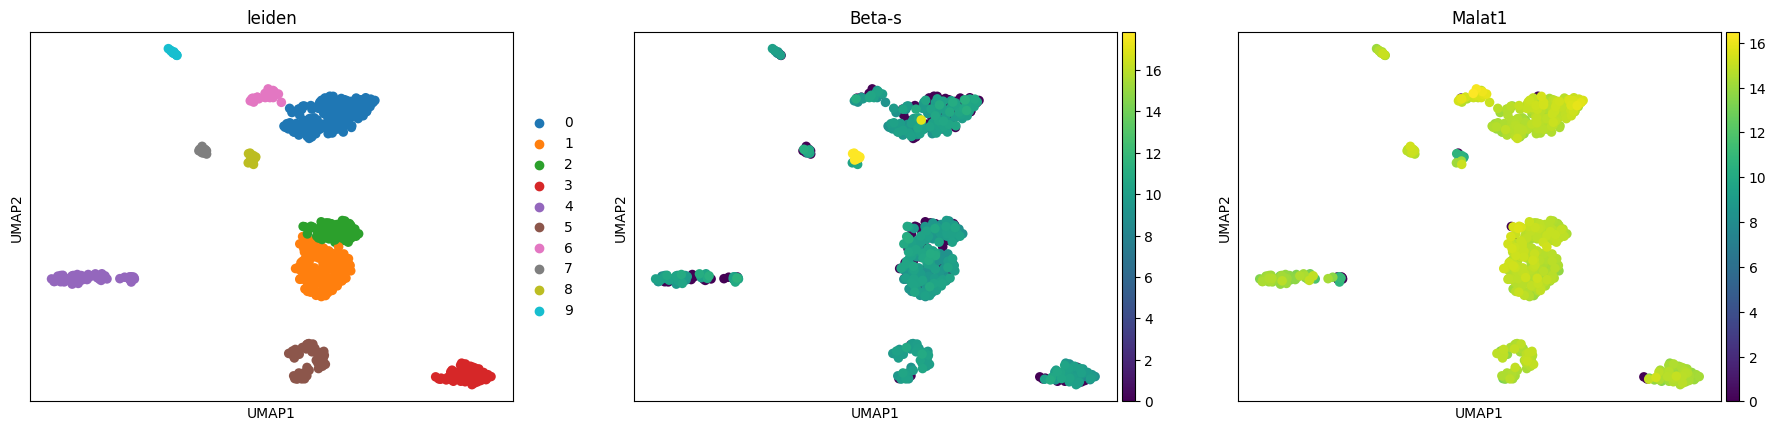

In [ ]:
sc.pl.umap(adata, color=['leiden', 'Beta-s', 'Malat1'])

In [ ]:
number_of_clusters = 8
number_of_genes = 20

names = adata.uns['rank_genes_groups']['names'][:number_of_genes]
# transform each element of names in a list
names = [list(x) for x in names]

df = pd.DataFrame(columns=['gene', 'cluster', 'rank'])

for i in range(0, number_of_clusters):
    to_add = [ [names[j][i], i, j] for j in range(number_of_genes)]
    to_add = pd.DataFrame(to_add, columns=['gene', 'cluster', 'rank'])
    df = pd.concat([df, to_add],  ignore_index=True)

df

,gene,cluster,rank
0,Cdh5,0,0
1,Ly6c1,0,1
2,Gpihbp1,0,2
3,Cd36,0,3
4,Fabp4,0,4
...,...,...,...
155,Rpl13a,7,15
156,Rps27,7,16
157,Rps15a,7,17
158,H3f3a,7,18


/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


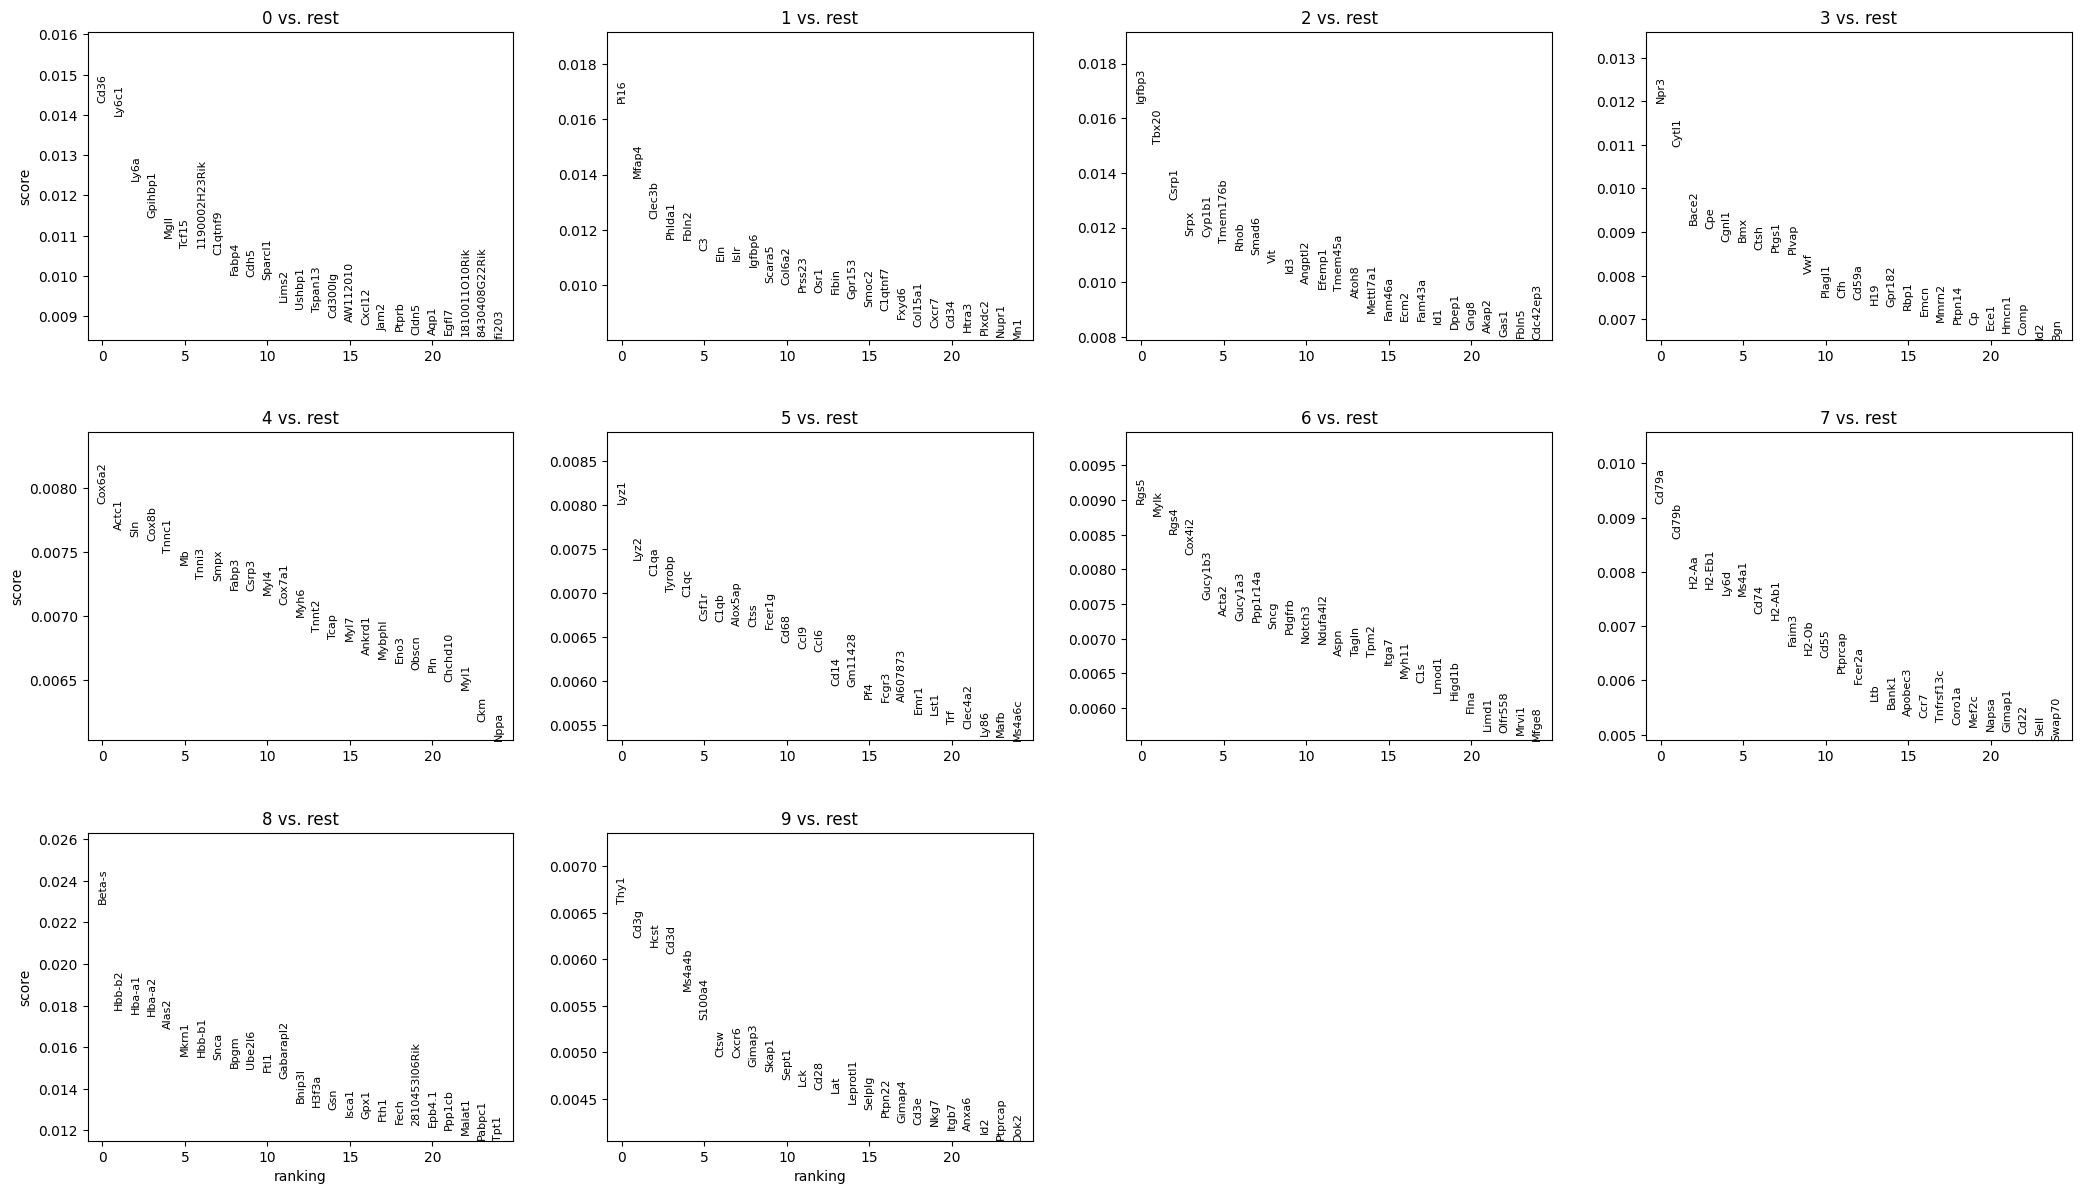

In [ ]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3') # seurat FindVariableFeatures

In [ ]:
# silouhette score
matrix = adata.X

from sklearn.metrics import silhouette_score
score = silhouette_score(matrix, labels, metric='euclidean')

# dataset with silouette score

df = pd.DataFrame([score], columns=['silhouette'])
df.to_csv(f'{save_path}/clustering_scores.csv', index=False)

/Users/paulmagos/miniconda3/envs/CHLPy/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

In [ ]:
sc.tl.umap(adata)

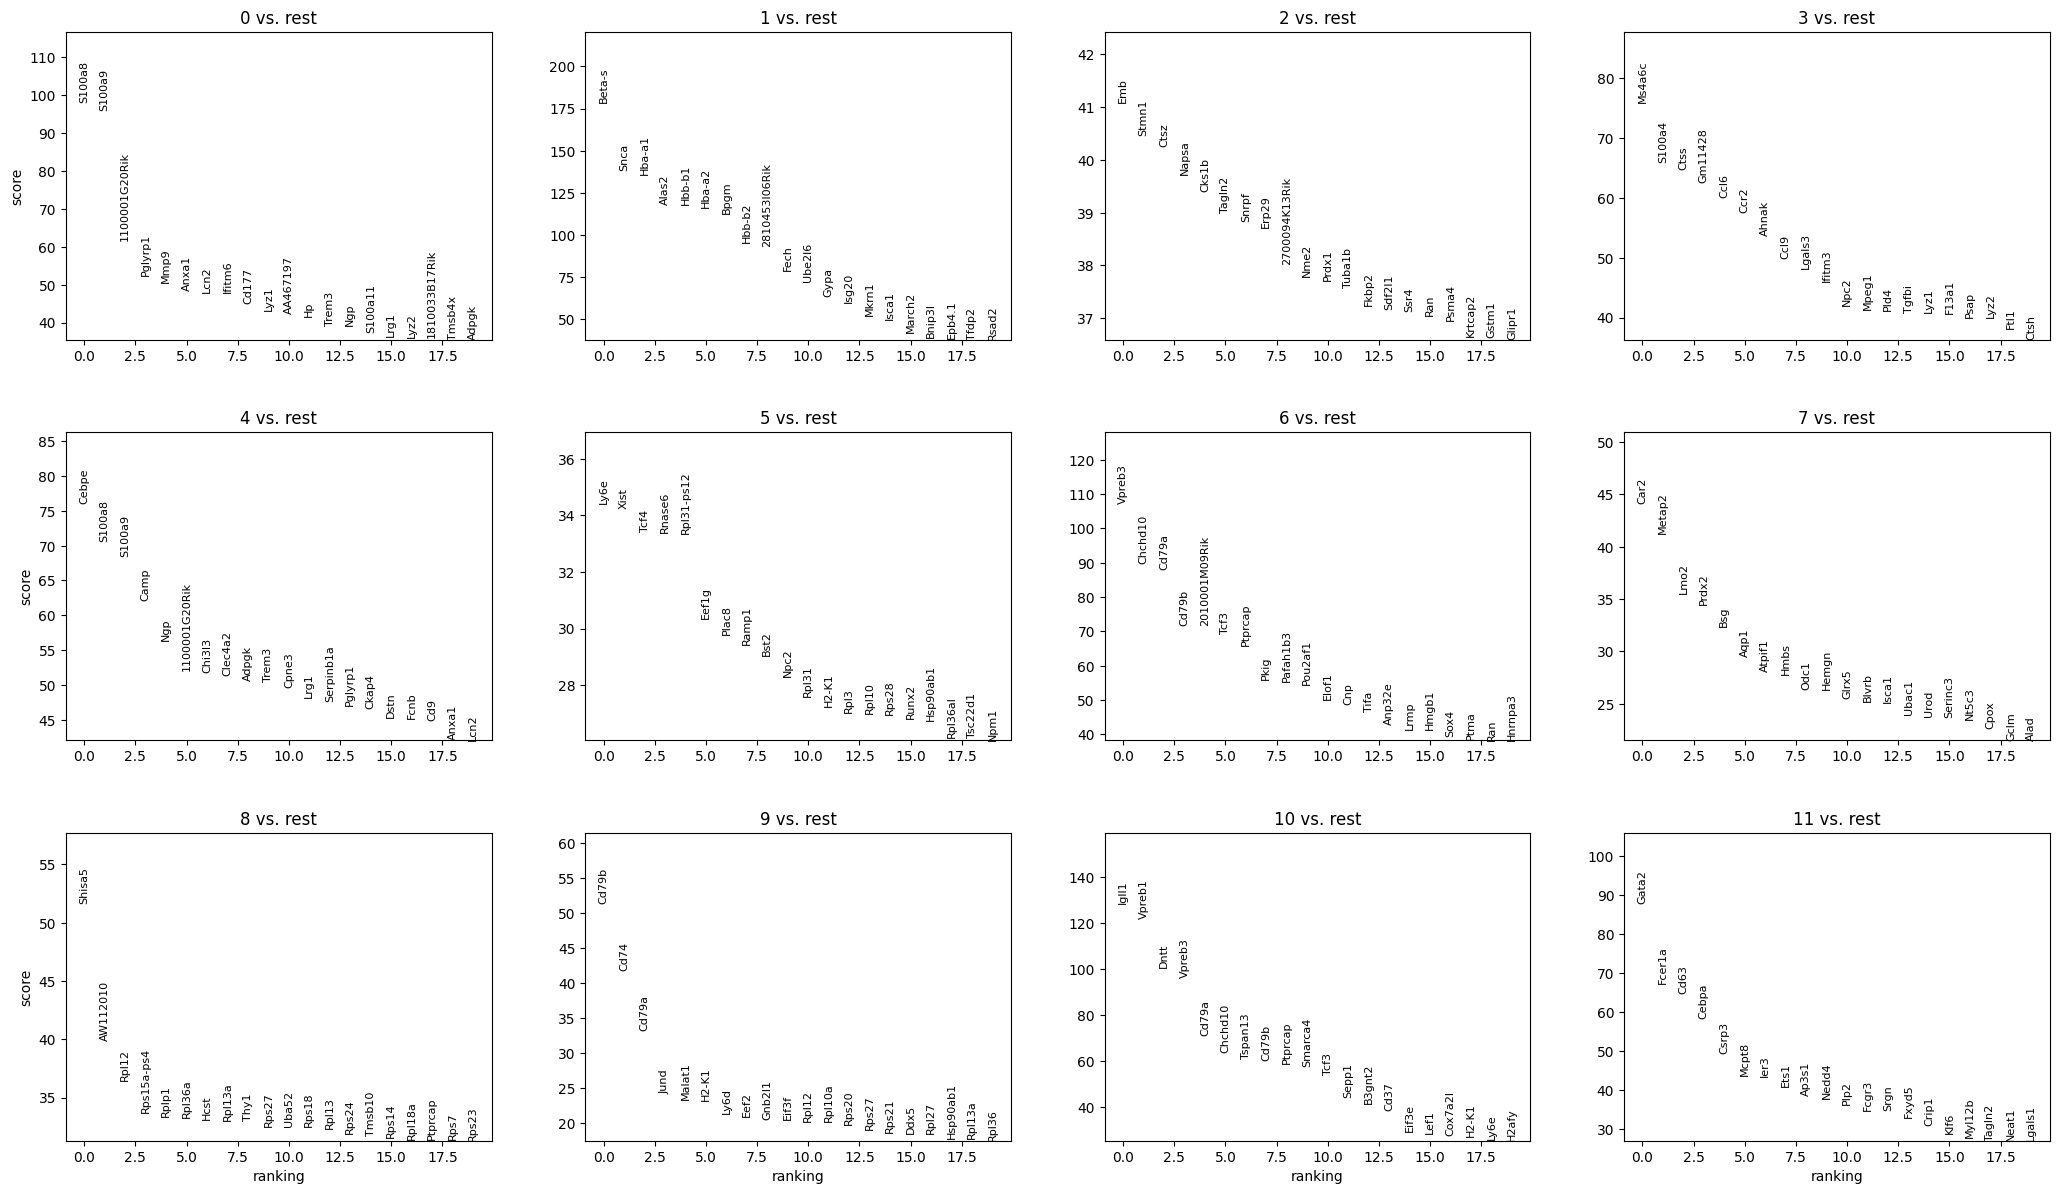

In [ ]:
ret = sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)